## Imports

In [1]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

from tqdm import tqdm

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## Model Settings

In [2]:
RANDOM_SEED = 1
LEARNING_RATE = 0.00001
BATCH_SIZE = 32
NUM_EPOCHS = 20

RESOLUTION = 200
NUM_FEATURES = RESOLUTION*RESOLUTION
NUM_CLASSES = 66

DEVICE = "cuda:0"
GRAYSCALE = False

In [4]:
transform = transforms.Compose([
    transforms.Resize(RESOLUTION),
    transforms.CenterCrop(RESOLUTION),
    transforms.ToTensor()
])

path = 'CV_data/dataset_subsampled'
dataset = datasets.ImageFolder(root=path, transform=transform)


# Get class to index mapping
class_to_idx = dataset.class_to_idx

# Define index to class mapping
idx_to_class = {v: k for k, v in class_to_idx.items()}

train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset into training set and test set
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size])


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

val_loader = DataLoader(dataset=val_dataset, 
                        batch_size=BATCH_SIZE, 
                        shuffle=False)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=True)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Labels:', labels)
    break


Image batch dimensions: torch.Size([32, 3, 200, 200])
Image label dimensions: torch.Size([32])
Labels: tensor([29,  5,  3,  3,  0, 33, 64, 25, 27, 49, 40, 55, 41, 44,  8, 64, 44,  0,
        47, 28, 46, 19, 28, 35, 26, 36, 48, 50, 36,  0, 42, 60])


In [5]:
from collections import Counter


train_classes = [dataset.targets[i] for i in train_dataset.indices]
class_weights = 1 / torch.tensor(list(dict(sorted(dict(Counter(train_classes)).items())).values()))
class_weights

tensor([0.0032, 0.0033, 0.0034, 0.0032, 0.0037, 0.0032, 0.0032, 0.0141, 0.0033,
        0.0175, 0.0033, 0.0033, 0.0033, 0.0080, 0.0035, 0.0063, 0.0032, 0.0147,
        0.0033, 0.0035, 0.0034, 0.0156, 0.0037, 0.0034, 0.0034, 0.0032, 0.0032,
        0.0035, 0.0035, 0.0033, 0.0034, 0.0062, 0.0035, 0.0139, 0.0031, 0.0034,
        0.0032, 0.0070, 0.0033, 0.0034, 0.0032, 0.0033, 0.0033, 0.0032, 0.0034,
        0.0143, 0.0064, 0.0033, 0.0033, 0.0070, 0.0032, 0.0034, 0.0036, 0.0152,
        0.0034, 0.0033, 0.0145, 0.0167, 0.0032, 0.0064, 0.0034, 0.0036, 0.0033,
        0.0143, 0.0036, 0.0105])

In [6]:
device = torch.device(DEVICE)
torch.manual_seed(0)

for epoch in range(2):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(device)
        y = y.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: 32
Epoch: 2 | Batch index: 0 | Batch size: 32


# Model

In [7]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet18(num_classes):
    """Constructs a ResNet-18 model."""
    model = ResNet(block=BasicBlock, 
                   layers=[2, 2, 2, 2],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model


In [8]:
torch.manual_seed(RANDOM_SEED)

model = resnet18(NUM_CLASSES)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

In [9]:
def compute_accuracy(model, data_loader, device, mode="train"):
    correct_pred, num_examples = 0, 0
    for batch_idx, (features, targets) in tqdm(enumerate(data_loader)):
            
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
        
        if not batch_idx % 50:
            accuracy = correct_pred.float() / num_examples * 100
            with open(f'CV_data/models/{model_name}-{LEARNING_RATE}-{mode}-accuracy.csv', 'a') as fp:
                fp.write(f"{epoch+1}, {batch_idx}, {accuracy}\n")
            correct_pred, num_examples = 0, 0



In [10]:
def compute_loss(model, data_loader, class_weights, device, mode="val"):
    losses = []
    dataset_len = len(data_loader)
    for batch_idx, (features, targets) in tqdm(enumerate(data_loader)):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
        class_weights = class_weights.to(DEVICE)
            
        logits, _ = model(features)
        loss = F.cross_entropy(logits, targets, weight=class_weights)
        losses.append(loss)
        
        if not batch_idx % 50:
            mean_loss = sum(losses) / len(losses)
            with open(f'CV_data/models/{model_name}-{LEARNING_RATE}-{mode}-loss.csv', 'a') as fp:
                fp.write(f"{epoch+1}, {batch_idx}, {mean_loss}\n")
            losses.clear()

In [11]:
model_name = "06-model"

## Training

In [12]:

start_time = time.time()

for epoch in range(NUM_EPOCHS):
        model.train()
        losses = []
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(DEVICE)
            targets = targets.to(DEVICE)
            class_weights = class_weights.to(DEVICE)

            ### FORWARD AND BACK PROP
            logits, probas = model(features)
            loss = F.cross_entropy(logits, targets, weight=class_weights)
            losses.append(loss)

            optimizer.zero_grad()

            loss.backward()

            ### UPDATE MODEL PARAMETERS
            optimizer.step()

            ### LOGGING
            if not batch_idx % 50:
                print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                       %(epoch+1, NUM_EPOCHS, batch_idx,
                         len(train_loader), loss))

                mean_loss = sum(losses) / len(losses)
                with open(f'CV_data/models/{model_name}-{LEARNING_RATE}-train-loss.csv', 'a') as fp:
                    fp.write(f"{epoch+1}, {batch_idx}, {mean_loss}\n")
                losses.clear()


        model.eval()
        with torch.set_grad_enabled(False): # save memory during inference
            compute_accuracy(model, train_loader, device=DEVICE, mode="train")
            compute_loss(model, val_loader, class_weights, device=DEVICE, mode="val")
            compute_accuracy(model, val_loader, device=DEVICE, mode="val")

        file_path = f'CV_data/models/{model_name}-{LEARNING_RATE}-epoch{epoch+1}.pth'
        torch.save(model.state_dict(), file_path)

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
    
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/020 | Batch 0000/0506 | Cost: 4.5413


/data/leuven/354/vsc35486/miniconda3/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 001/020 | Batch 0050/0506 | Cost: 3.7945
Epoch: 001/020 | Batch 0100/0506 | Cost: 3.9928
Epoch: 001/020 | Batch 0150/0506 | Cost: 3.6567
Epoch: 001/020 | Batch 0200/0506 | Cost: 3.4497
Epoch: 001/020 | Batch 0250/0506 | Cost: 3.0245
Epoch: 001/020 | Batch 0300/0506 | Cost: 2.8313
Epoch: 001/020 | Batch 0350/0506 | Cost: 2.5568
Epoch: 001/020 | Batch 0400/0506 | Cost: 2.5471
Epoch: 001/020 | Batch 0450/0506 | Cost: 1.9169
Epoch: 001/020 | Batch 0500/0506 | Cost: 1.9101


506it [01:02,  8.04it/s]
169it [00:20,  8.06it/s]
169it [00:19,  8.81it/s]


Time elapsed: 3.05 min
Epoch: 002/020 | Batch 0000/0506 | Cost: 1.9193
Epoch: 002/020 | Batch 0050/0506 | Cost: 1.8691
Epoch: 002/020 | Batch 0100/0506 | Cost: 2.0838
Epoch: 002/020 | Batch 0150/0506 | Cost: 1.5213
Epoch: 002/020 | Batch 0200/0506 | Cost: 1.5876
Epoch: 002/020 | Batch 0250/0506 | Cost: 1.5185
Epoch: 002/020 | Batch 0300/0506 | Cost: 1.3550
Epoch: 002/020 | Batch 0350/0506 | Cost: 1.7083
Epoch: 002/020 | Batch 0400/0506 | Cost: 1.4510
Epoch: 002/020 | Batch 0450/0506 | Cost: 1.2942
Epoch: 002/020 | Batch 0500/0506 | Cost: 1.2378


506it [01:02,  8.04it/s]
169it [00:18,  8.92it/s]
169it [00:18,  9.09it/s]


Time elapsed: 5.91 min
Epoch: 003/020 | Batch 0000/0506 | Cost: 1.4094
Epoch: 003/020 | Batch 0050/0506 | Cost: 1.2614
Epoch: 003/020 | Batch 0100/0506 | Cost: 1.2734
Epoch: 003/020 | Batch 0150/0506 | Cost: 1.4140
Epoch: 003/020 | Batch 0200/0506 | Cost: 1.0426
Epoch: 003/020 | Batch 0250/0506 | Cost: 1.1072
Epoch: 003/020 | Batch 0300/0506 | Cost: 0.9351
Epoch: 003/020 | Batch 0350/0506 | Cost: 0.6434
Epoch: 003/020 | Batch 0400/0506 | Cost: 1.5298
Epoch: 003/020 | Batch 0450/0506 | Cost: 0.9225
Epoch: 003/020 | Batch 0500/0506 | Cost: 0.9445


506it [01:15,  6.73it/s]
169it [00:18,  8.94it/s]
169it [00:18,  9.13it/s]


Time elapsed: 8.96 min
Epoch: 004/020 | Batch 0000/0506 | Cost: 0.8170
Epoch: 004/020 | Batch 0050/0506 | Cost: 0.8126
Epoch: 004/020 | Batch 0100/0506 | Cost: 0.7968
Epoch: 004/020 | Batch 0150/0506 | Cost: 1.0389
Epoch: 004/020 | Batch 0200/0506 | Cost: 1.0310
Epoch: 004/020 | Batch 0250/0506 | Cost: 1.1177
Epoch: 004/020 | Batch 0300/0506 | Cost: 0.9976
Epoch: 004/020 | Batch 0350/0506 | Cost: 0.7434
Epoch: 004/020 | Batch 0400/0506 | Cost: 0.8968
Epoch: 004/020 | Batch 0450/0506 | Cost: 0.6796
Epoch: 004/020 | Batch 0500/0506 | Cost: 0.7033


506it [01:01,  8.20it/s]
169it [00:18,  9.06it/s]
169it [00:18,  8.97it/s]


Time elapsed: 11.78 min
Epoch: 005/020 | Batch 0000/0506 | Cost: 0.7143
Epoch: 005/020 | Batch 0050/0506 | Cost: 0.5272
Epoch: 005/020 | Batch 0100/0506 | Cost: 0.8323
Epoch: 005/020 | Batch 0150/0506 | Cost: 0.4158
Epoch: 005/020 | Batch 0200/0506 | Cost: 0.5287
Epoch: 005/020 | Batch 0250/0506 | Cost: 0.6436
Epoch: 005/020 | Batch 0300/0506 | Cost: 1.0093
Epoch: 005/020 | Batch 0350/0506 | Cost: 0.5807
Epoch: 005/020 | Batch 0400/0506 | Cost: 0.6191
Epoch: 005/020 | Batch 0450/0506 | Cost: 0.2957
Epoch: 005/020 | Batch 0500/0506 | Cost: 0.7876


506it [01:01,  8.19it/s]
169it [00:18,  9.07it/s]
169it [00:18,  9.09it/s]


Time elapsed: 14.59 min
Epoch: 006/020 | Batch 0000/0506 | Cost: 0.4909
Epoch: 006/020 | Batch 0050/0506 | Cost: 0.6072
Epoch: 006/020 | Batch 0100/0506 | Cost: 0.5339
Epoch: 006/020 | Batch 0150/0506 | Cost: 0.7372
Epoch: 006/020 | Batch 0200/0506 | Cost: 0.7065
Epoch: 006/020 | Batch 0250/0506 | Cost: 0.8208
Epoch: 006/020 | Batch 0300/0506 | Cost: 0.5515
Epoch: 006/020 | Batch 0350/0506 | Cost: 0.9198
Epoch: 006/020 | Batch 0400/0506 | Cost: 0.5403
Epoch: 006/020 | Batch 0450/0506 | Cost: 0.4340
Epoch: 006/020 | Batch 0500/0506 | Cost: 0.4166


506it [01:02,  8.08it/s]
169it [00:19,  8.82it/s]
169it [00:20,  8.09it/s]


Time elapsed: 17.46 min
Epoch: 007/020 | Batch 0000/0506 | Cost: 0.6077
Epoch: 007/020 | Batch 0050/0506 | Cost: 0.8738
Epoch: 007/020 | Batch 0100/0506 | Cost: 0.5662
Epoch: 007/020 | Batch 0150/0506 | Cost: 0.6145
Epoch: 007/020 | Batch 0200/0506 | Cost: 0.4674
Epoch: 007/020 | Batch 0250/0506 | Cost: 0.4114
Epoch: 007/020 | Batch 0300/0506 | Cost: 1.0122
Epoch: 007/020 | Batch 0350/0506 | Cost: 0.8236
Epoch: 007/020 | Batch 0400/0506 | Cost: 0.4331
Epoch: 007/020 | Batch 0450/0506 | Cost: 0.7019
Epoch: 007/020 | Batch 0500/0506 | Cost: 1.0627


506it [01:02,  8.08it/s]
169it [00:18,  8.93it/s]
169it [00:19,  8.89it/s]


Time elapsed: 20.30 min
Epoch: 008/020 | Batch 0000/0506 | Cost: 0.4603
Epoch: 008/020 | Batch 0050/0506 | Cost: 0.2383
Epoch: 008/020 | Batch 0100/0506 | Cost: 0.9053
Epoch: 008/020 | Batch 0150/0506 | Cost: 0.3607
Epoch: 008/020 | Batch 0200/0506 | Cost: 0.4546
Epoch: 008/020 | Batch 0250/0506 | Cost: 0.5770
Epoch: 008/020 | Batch 0300/0506 | Cost: 0.2011
Epoch: 008/020 | Batch 0350/0506 | Cost: 0.4527
Epoch: 008/020 | Batch 0400/0506 | Cost: 0.9456
Epoch: 008/020 | Batch 0450/0506 | Cost: 0.2875
Epoch: 008/020 | Batch 0500/0506 | Cost: 0.2260


506it [01:02,  8.07it/s]
169it [00:18,  9.02it/s]
169it [00:18,  8.93it/s]


Time elapsed: 23.14 min
Epoch: 009/020 | Batch 0000/0506 | Cost: 0.4989
Epoch: 009/020 | Batch 0050/0506 | Cost: 0.2988
Epoch: 009/020 | Batch 0100/0506 | Cost: 0.4250
Epoch: 009/020 | Batch 0150/0506 | Cost: 0.4839
Epoch: 009/020 | Batch 0200/0506 | Cost: 0.5937
Epoch: 009/020 | Batch 0250/0506 | Cost: 0.6306
Epoch: 009/020 | Batch 0300/0506 | Cost: 0.1729
Epoch: 009/020 | Batch 0350/0506 | Cost: 0.5597
Epoch: 009/020 | Batch 0400/0506 | Cost: 0.4346
Epoch: 009/020 | Batch 0450/0506 | Cost: 0.2075
Epoch: 009/020 | Batch 0500/0506 | Cost: 0.2430


506it [01:02,  8.05it/s]
169it [00:19,  8.81it/s]
169it [00:19,  8.85it/s]


Time elapsed: 26.00 min
Epoch: 010/020 | Batch 0000/0506 | Cost: 0.3700
Epoch: 010/020 | Batch 0050/0506 | Cost: 0.1252
Epoch: 010/020 | Batch 0100/0506 | Cost: 0.4425
Epoch: 010/020 | Batch 0150/0506 | Cost: 0.8178
Epoch: 010/020 | Batch 0200/0506 | Cost: 0.5458
Epoch: 010/020 | Batch 0250/0506 | Cost: 0.2898
Epoch: 010/020 | Batch 0300/0506 | Cost: 0.2492
Epoch: 010/020 | Batch 0350/0506 | Cost: 0.1504
Epoch: 010/020 | Batch 0400/0506 | Cost: 0.2318
Epoch: 010/020 | Batch 0450/0506 | Cost: 0.2319
Epoch: 010/020 | Batch 0500/0506 | Cost: 0.2971


506it [01:02,  8.14it/s]
169it [00:18,  9.02it/s]
169it [00:18,  8.98it/s]


Time elapsed: 28.83 min
Epoch: 011/020 | Batch 0000/0506 | Cost: 0.2519
Epoch: 011/020 | Batch 0050/0506 | Cost: 0.3013
Epoch: 011/020 | Batch 0100/0506 | Cost: 0.1154
Epoch: 011/020 | Batch 0150/0506 | Cost: 0.3996
Epoch: 011/020 | Batch 0200/0506 | Cost: 0.2635
Epoch: 011/020 | Batch 0250/0506 | Cost: 0.3194
Epoch: 011/020 | Batch 0300/0506 | Cost: 0.3247
Epoch: 011/020 | Batch 0350/0506 | Cost: 0.7417
Epoch: 011/020 | Batch 0400/0506 | Cost: 0.3648
Epoch: 011/020 | Batch 0450/0506 | Cost: 0.0724
Epoch: 011/020 | Batch 0500/0506 | Cost: 0.3858


506it [01:02,  8.10it/s]
169it [00:18,  9.06it/s]
169it [00:18,  9.11it/s]


Time elapsed: 31.66 min
Epoch: 012/020 | Batch 0000/0506 | Cost: 0.1401
Epoch: 012/020 | Batch 0050/0506 | Cost: 0.4697
Epoch: 012/020 | Batch 0100/0506 | Cost: 0.1981
Epoch: 012/020 | Batch 0150/0506 | Cost: 0.2076
Epoch: 012/020 | Batch 0200/0506 | Cost: 0.0773
Epoch: 012/020 | Batch 0250/0506 | Cost: 0.3521
Epoch: 012/020 | Batch 0300/0506 | Cost: 0.3925
Epoch: 012/020 | Batch 0350/0506 | Cost: 0.1803
Epoch: 012/020 | Batch 0400/0506 | Cost: 0.2390
Epoch: 012/020 | Batch 0450/0506 | Cost: 0.4056
Epoch: 012/020 | Batch 0500/0506 | Cost: 0.2856


506it [01:02,  8.05it/s]
169it [00:18,  8.94it/s]
169it [00:19,  8.86it/s]


Time elapsed: 34.50 min
Epoch: 013/020 | Batch 0000/0506 | Cost: 0.3497
Epoch: 013/020 | Batch 0050/0506 | Cost: 0.2181
Epoch: 013/020 | Batch 0100/0506 | Cost: 0.3449
Epoch: 013/020 | Batch 0150/0506 | Cost: 0.1208
Epoch: 013/020 | Batch 0200/0506 | Cost: 0.4617
Epoch: 013/020 | Batch 0250/0506 | Cost: 0.2296
Epoch: 013/020 | Batch 0300/0506 | Cost: 0.4196
Epoch: 013/020 | Batch 0350/0506 | Cost: 0.0856
Epoch: 013/020 | Batch 0400/0506 | Cost: 0.1345
Epoch: 013/020 | Batch 0450/0506 | Cost: 0.3987
Epoch: 013/020 | Batch 0500/0506 | Cost: 0.0583


506it [01:01,  8.16it/s]
169it [00:19,  8.89it/s]
169it [00:18,  9.01it/s]


Time elapsed: 37.33 min
Epoch: 014/020 | Batch 0000/0506 | Cost: 0.1824
Epoch: 014/020 | Batch 0050/0506 | Cost: 0.1116
Epoch: 014/020 | Batch 0100/0506 | Cost: 0.1068
Epoch: 014/020 | Batch 0150/0506 | Cost: 0.3455
Epoch: 014/020 | Batch 0200/0506 | Cost: 0.3132
Epoch: 014/020 | Batch 0250/0506 | Cost: 0.2457
Epoch: 014/020 | Batch 0300/0506 | Cost: 0.1272
Epoch: 014/020 | Batch 0350/0506 | Cost: 0.2125
Epoch: 014/020 | Batch 0400/0506 | Cost: 0.2549
Epoch: 014/020 | Batch 0450/0506 | Cost: 0.0677
Epoch: 014/020 | Batch 0500/0506 | Cost: 0.0792


506it [01:02,  8.08it/s]
169it [00:18,  8.94it/s]
169it [00:19,  8.84it/s]


Time elapsed: 40.18 min
Epoch: 015/020 | Batch 0000/0506 | Cost: 0.1363
Epoch: 015/020 | Batch 0050/0506 | Cost: 0.1441
Epoch: 015/020 | Batch 0100/0506 | Cost: 0.1467
Epoch: 015/020 | Batch 0150/0506 | Cost: 0.2681
Epoch: 015/020 | Batch 0200/0506 | Cost: 0.2795
Epoch: 015/020 | Batch 0250/0506 | Cost: 0.1323
Epoch: 015/020 | Batch 0300/0506 | Cost: 0.0583
Epoch: 015/020 | Batch 0350/0506 | Cost: 0.1595
Epoch: 015/020 | Batch 0400/0506 | Cost: 0.1696
Epoch: 015/020 | Batch 0450/0506 | Cost: 0.0694
Epoch: 015/020 | Batch 0500/0506 | Cost: 0.2919


506it [01:03,  8.00it/s]
169it [00:18,  8.93it/s]
169it [00:22,  7.63it/s]


Time elapsed: 43.09 min
Epoch: 016/020 | Batch 0000/0506 | Cost: 0.2309
Epoch: 016/020 | Batch 0050/0506 | Cost: 0.3523
Epoch: 016/020 | Batch 0100/0506 | Cost: 0.2902
Epoch: 016/020 | Batch 0150/0506 | Cost: 0.0890
Epoch: 016/020 | Batch 0200/0506 | Cost: 0.0560
Epoch: 016/020 | Batch 0250/0506 | Cost: 0.3325
Epoch: 016/020 | Batch 0300/0506 | Cost: 0.1852
Epoch: 016/020 | Batch 0350/0506 | Cost: 0.2836
Epoch: 016/020 | Batch 0400/0506 | Cost: 0.3252
Epoch: 016/020 | Batch 0450/0506 | Cost: 0.2363
Epoch: 016/020 | Batch 0500/0506 | Cost: 0.1626


506it [01:06,  7.58it/s]
169it [00:21,  7.79it/s]
169it [00:19,  8.86it/s]


Time elapsed: 46.26 min
Epoch: 017/020 | Batch 0000/0506 | Cost: 0.0564
Epoch: 017/020 | Batch 0050/0506 | Cost: 0.0660
Epoch: 017/020 | Batch 0100/0506 | Cost: 0.1627
Epoch: 017/020 | Batch 0150/0506 | Cost: 0.5565
Epoch: 017/020 | Batch 0200/0506 | Cost: 0.0516
Epoch: 017/020 | Batch 0250/0506 | Cost: 0.3006
Epoch: 017/020 | Batch 0300/0506 | Cost: 0.0821
Epoch: 017/020 | Batch 0350/0506 | Cost: 0.1492
Epoch: 017/020 | Batch 0400/0506 | Cost: 0.2040
Epoch: 017/020 | Batch 0450/0506 | Cost: 0.1082
Epoch: 017/020 | Batch 0500/0506 | Cost: 0.0432


506it [01:02,  8.12it/s]
169it [00:18,  8.90it/s]
169it [00:18,  9.01it/s]


Time elapsed: 49.10 min
Epoch: 018/020 | Batch 0000/0506 | Cost: 0.0692
Epoch: 018/020 | Batch 0050/0506 | Cost: 0.0672
Epoch: 018/020 | Batch 0100/0506 | Cost: 0.0325
Epoch: 018/020 | Batch 0150/0506 | Cost: 0.3049
Epoch: 018/020 | Batch 0200/0506 | Cost: 0.1715
Epoch: 018/020 | Batch 0250/0506 | Cost: 0.1277
Epoch: 018/020 | Batch 0300/0506 | Cost: 0.1706
Epoch: 018/020 | Batch 0350/0506 | Cost: 0.0928
Epoch: 018/020 | Batch 0400/0506 | Cost: 0.7055
Epoch: 018/020 | Batch 0450/0506 | Cost: 0.0431
Epoch: 018/020 | Batch 0500/0506 | Cost: 0.5920


506it [01:02,  8.05it/s]
169it [00:18,  9.10it/s]
169it [00:19,  8.87it/s]


Time elapsed: 51.95 min
Epoch: 019/020 | Batch 0000/0506 | Cost: 0.4937
Epoch: 019/020 | Batch 0050/0506 | Cost: 0.0300
Epoch: 019/020 | Batch 0100/0506 | Cost: 0.1831
Epoch: 019/020 | Batch 0150/0506 | Cost: 0.0757
Epoch: 019/020 | Batch 0200/0506 | Cost: 0.2686
Epoch: 019/020 | Batch 0250/0506 | Cost: 0.0451
Epoch: 019/020 | Batch 0300/0506 | Cost: 0.1199
Epoch: 019/020 | Batch 0350/0506 | Cost: 0.1721
Epoch: 019/020 | Batch 0400/0506 | Cost: 0.0175
Epoch: 019/020 | Batch 0450/0506 | Cost: 0.1265
Epoch: 019/020 | Batch 0500/0506 | Cost: 0.0580


506it [01:02,  8.05it/s]
169it [00:18,  8.96it/s]
169it [00:18,  9.00it/s]


Time elapsed: 54.79 min
Epoch: 020/020 | Batch 0000/0506 | Cost: 0.2164
Epoch: 020/020 | Batch 0050/0506 | Cost: 0.0406
Epoch: 020/020 | Batch 0100/0506 | Cost: 0.0710
Epoch: 020/020 | Batch 0150/0506 | Cost: 0.3282
Epoch: 020/020 | Batch 0200/0506 | Cost: 0.1141
Epoch: 020/020 | Batch 0250/0506 | Cost: 0.1745
Epoch: 020/020 | Batch 0300/0506 | Cost: 0.1743
Epoch: 020/020 | Batch 0350/0506 | Cost: 0.0738
Epoch: 020/020 | Batch 0400/0506 | Cost: 0.0862
Epoch: 020/020 | Batch 0450/0506 | Cost: 0.1281
Epoch: 020/020 | Batch 0500/0506 | Cost: 0.0615


506it [01:03,  7.99it/s]
169it [00:18,  9.04it/s]
169it [00:18,  9.10it/s]


Time elapsed: 57.64 min
Total Training Time: 57.64 min


## Evaluation

In [12]:
DEVICE = "cuda:0"
device = torch.device(DEVICE)

torch.manual_seed(RANDOM_SEED)

model_weights = torch.load(f"CV_data/models/{model_name}-{LEARNING_RATE}-epoch20.pth", map_location=torch.device('cpu'))

model = resnet18(NUM_CLASSES) 

# Loading the weights to the model
model.load_state_dict(model_weights)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Confusion matrix

!pip install seaborn

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

model.eval()
with torch.set_grad_enabled(False):
    for inputs, labels in tqdm(test_loader):
            inputs = inputs.to(DEVICE)
            _, classes = model(inputs) # Feed Network

            output = (torch.max(torch.exp(classes), 1)[1]).data.cpu().numpy()
            y_pred.extend(output) # Save Prediction

            labels = labels.data.cpu().numpy()
            y_true.extend(labels) # Save Truth

 11%|█         | 19/169 [00:03<00:25,  5.86it/s]/data/leuven/354/vsc35486/miniconda3/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 169/169 [00:26<00:00,  6.47it/s]


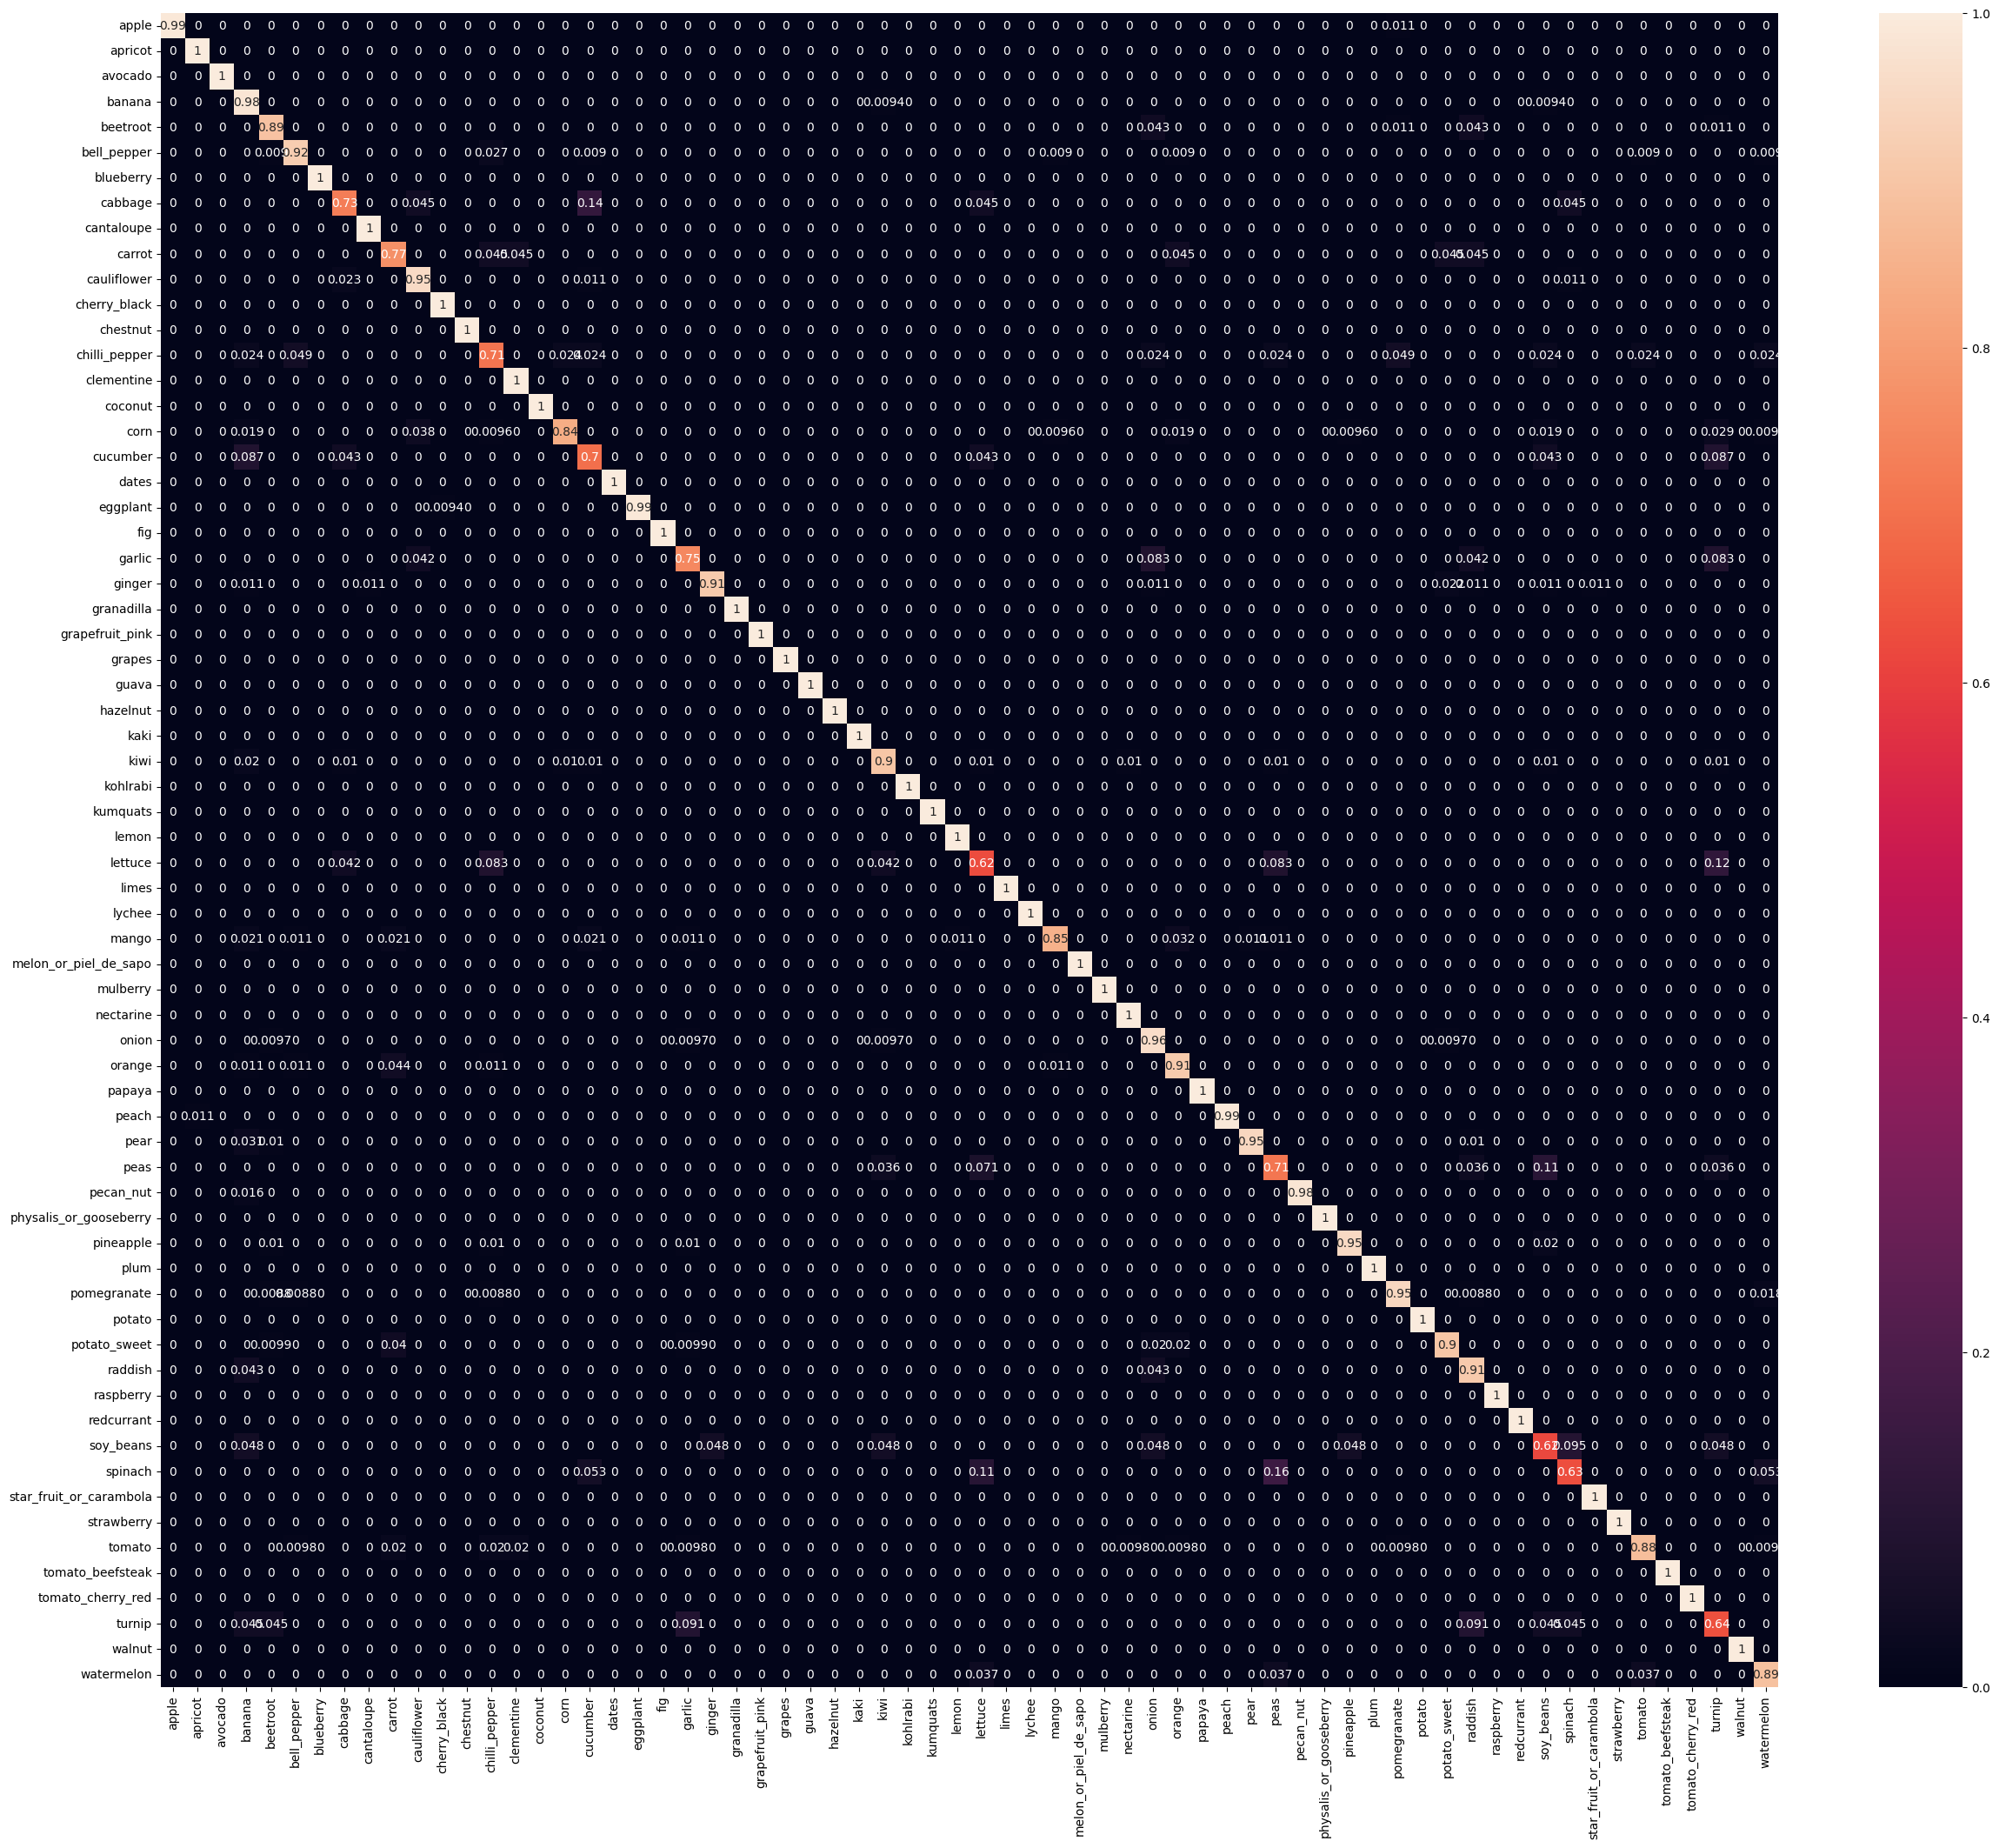

In [16]:
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
classes = dataset.class_to_idx.keys()
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize=(30, 25))
sn.heatmap(df_cm, annot=True)
plt.savefig(f'CV_data/conf_matrix/{model_name}-output.pdf')

# Test examples

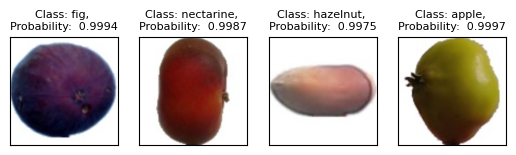

In [17]:
for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break

NUM_IMG = 4
fig, axs = plt.subplots(1, NUM_IMG)
imgs = []
classes = []

for idx in range(NUM_IMG):
    nhwc_img = np.transpose(features[idx], axes=(1, 2, 0))
    imgs.append(nhwc_img)

    model.eval()
    _ , probas = model(features.to(device)[idx, None])
    probas = probas.cpu().detach().numpy()

    classes.append(
        {"class": idx_to_class[np.argmax(probas[0])],
         "proba": np.max(probas[0])})

for i, ax in enumerate(axs.flat):
    if i < len(imgs):
        ax.imshow(imgs[i])
        ax.set_title(f'Class: {classes[i]["class"]}, \nProbability:  {classes[i]["proba"]:.4f}', fontsize=8)
    ax.set_xticks([])
    ax.set_yticks([])
    

# for idx in range(NUM_IMG):
    # print("Class: ", classes[idx]["class"], "\nProbability: ", classes[idx]["proba"], '\n')

# Own photos

In [14]:
import os
path = "CV_data/own_photos/"
path = "CV_data/own_photos_no_background/"
classes = os.listdir(path)
classes = [fldr for fldr in classes if not fldr.startswith('.')]

print(classes)

transform = transforms.Compose([
    transforms.Resize(100),
    transforms.Resize(RESOLUTION),
    transforms.CenterCrop(RESOLUTION),
    transforms.ToTensor()
])

custom_test_dataset = datasets.ImageFolder(root=path, transform=transform)

custom_test_loader = DataLoader(dataset=custom_test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=True)


['mango', 'banana', 'apple']


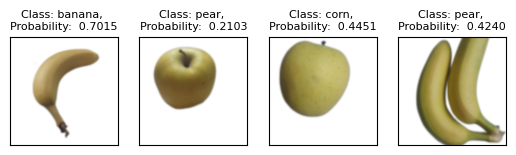

In [23]:
for batch_idx, (features, targets) in enumerate(custom_test_loader):

    features = features
    targets = targets
    break

NUM_IMG = 4
fig, axs = plt.subplots(1, NUM_IMG)
imgs = []
classes = []

for idx in range(NUM_IMG):
    nhwc_img = np.transpose(features[idx], axes=(1, 2, 0))
    imgs.append(nhwc_img)

    model.eval()
    _ , probas = model(features.to(device)[idx, None])
    probas = probas.cpu().detach().numpy()

    classes.append(
        {"class": idx_to_class[np.argmax(probas[0])],
         "proba": np.max(probas[0])})

for i, ax in enumerate(axs.flat):
    if i < len(imgs):
        ax.imshow(imgs[i])
        ax.set_title(f'Class: {classes[i]["class"]}, \nProbability:  {classes[i]["proba"]:.4f}', fontsize=8)
    ax.set_xticks([])
    ax.set_yticks([])

In [18]:
from lib.nutrifacts import retrieve_nutrition_facts
import json

from IPython.core.display import HTML
HTML("&micro;")

print(json.dumps(retrieve_nutrition_facts(classes[2]["class"]), indent=4))

{'Food_Group': 'Vegetables', 'Food Name': 'Sweetcorn boiled', 'Energy(kcal)': 74, 'Water(g)': '82', 'Protein(g)': '2,5', 'Fat(g)': '1,4', 'Fatty_acids_total(g)': '1,3', 'Fatty acids saturated total(g)': '0,2', 'Carbohydrate(g)': '11,6', 'Sugar(g)': '8,1', 'Starch(g)': '3,5', 'Fiber dietary total(g)': '2,5', 'Na(mg)': 1.0, 'K(mg)': 250.0, 'Ca(mg)': 11.0, 'P(mg)': 100.0, 'Mg(mg)': 45.0, 'Fe(mg)': '0,5', 'Cu(mg)': '0,04', 'Se(µg)': 0.0, 'Zn(mg)': '0,4', 'Id(µg)': '3,3', 'Vitamin_D(µg)': '0', 'Vitamin_E(mg)': '0,9', 'Vitamin_K(µg)': '0,4', 'Vitamin_B1(mg)': '0,12', 'Vitamin_B2(mg)': '0,07', 'Vitamin_B6(mg)': '0,1', 'Vitamin_B12(µg)': '0', 'Vitamin_B3(mg)': '1,7', 'Vitamin_C(mg)': 7.0, 'Vitamin_A': 886.0}
{
    "Food Name": "Sweetcorn boiled",
    "Energy(kcal)": 74,
    "Water(g)": 82.0,
    "Protein(g)": 2.5,
    "Fat(g)": 1.4,
    "Fatty_acids_total(g)": 1.3,
    "Fatty acids saturated total(g)": 0.2,
    "Carbohydrate(g)": 11.6,
    "Sugar(g)": 8.1,
    "Starch(g)": 3.5,
    "Fiber diet